In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from src.model import MineSweeperDataset, PatchMLPModel, OnHotEncodingTransform, Game

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [3]:
train = Game(n = 10000)
train.random_open(0.5)
train.random_flags(0.3)
test = Game(n = 100)
test.random_open(0.5)
test.random_flags(0.3)
transform = OnHotEncodingTransform(2)
training_data = MineSweeperDataset(train, transform)
test_data = MineSweeperDataset(test, transform)
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)
model = PatchMLPModel(2)
optimizer = torch.optim.Adam(model.model.parameters(), lr=0.0001)

In [4]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(train_dataloader, optimizer, device)
    model.test(test_dataloader, device)

Epoch 1
-------------------------------


In [5]:
import plotly_express as px
import pandas as pd
df = pd.DataFrame({'train': model.train_loss_log, 'test': model.test_loss_log})
px.line(df)

In [2]:
g = Game(16, 30, 99, n=1)
g.random_open(0.3)
g.random_flags(0.3)

In [7]:
x, _ = model.transform(g.game_state()[0], g.mines_n, g.mines)
p = model.model(x.unsqueeze(0)).view(g.mines.shape).cpu().detach().numpy()

In [11]:
import matplotlib
matplotlib.scale.get_scale_names()

['asinh', 'function', 'functionlog', 'linear', 'log', 'logit', 'symlog']

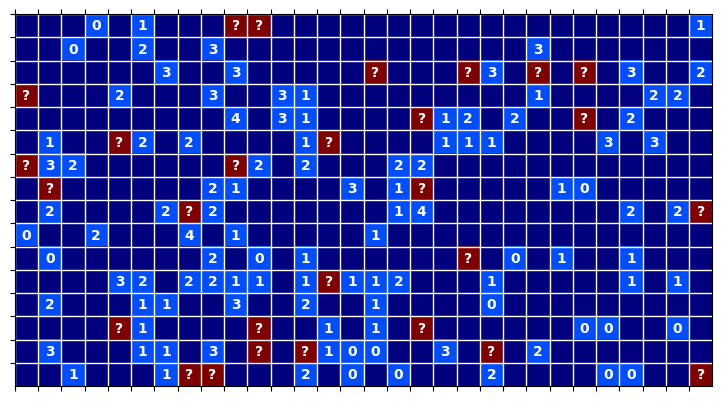

<Axes: >

In [4]:
g.pyplot_game(0)